In [1]:
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
from computage.deage.kdm import KlemeraDoubalEstimator

# PLS test

In [2]:
def plot_directions(ax, X, j=3, prefix=''):
    for i, comp in enumerate(X):
        ax.arrow(0, 0, comp[0], comp[1],
            label=f"{prefix} axis {i+1}",
            width=0.1,
            color=f"C{i + j}",
            )

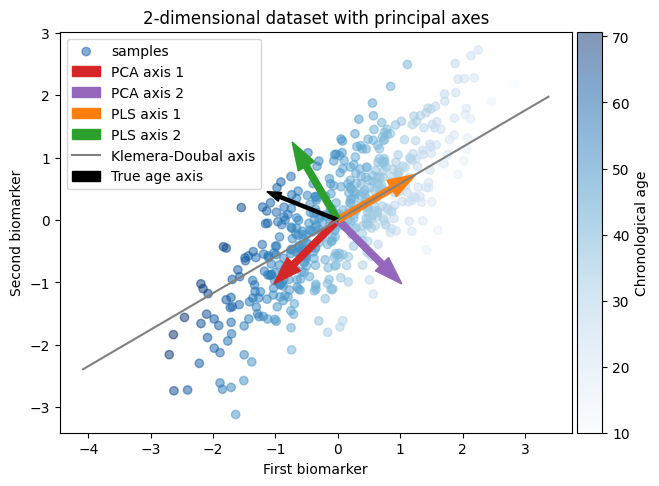

In [11]:
rng = np.random.RandomState(0)
n_samples = 500
age_axis = np.array([-0.5, 0.2]) #true age axis
age_axis /= np.linalg.norm(age_axis)

cov = [[3, 2.8], [2.8, 4]]
X = rng.multivariate_normal(mean=[0, 0], cov=cov, size=n_samples)
X = (X - X.mean(axis=0)) / X.std(axis=0, ddof=1)
y = X.dot(age_axis)*100.0 + rng.normal(size=n_samples) / 2
y = (y - y.min()) / y.max() * 30 + 10 # make age


pca = PCA(n_components=2).fit(X)
pls = PLSRegression(n_components=2).fit(X, y)

kdm = KlemeraDoubalEstimator(feature_selection_method='all')
kdm.fit(pd.DataFrame(X), y.ravel())
m = kdm.model
t = np.linspace(0, 90, 100)
X_kdm = np.zeros((100, 2))
X_kdm[:, 0] = m.loc[0, 'slope'] * t + m.loc[0, 'intercept']
X_kdm[:, 1] = m.loc[1, 'slope'] * t + m.loc[1, 'intercept']

from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
im = plt.scatter(X[:, 0], X[:, 1], alpha=0.5, label="samples", c=y, cmap='Blues')

plot_directions(ax, pca.components_, j=3, prefix='PCA')
plot_directions(ax, pls.x_weights_.T, j=1, prefix='PLS')
plt.plot(X_kdm[:, 0], X_kdm[:, 1], color='grey', label='Klemera-Doubal axis')

ax.arrow(0, 0, age_axis[0], age_axis[1], 
            label="True age axis",
            width=0.05,
            color='k',
            )

plt.gca().set(
    aspect="equal",
    title="2-dimensional dataset with principal axes",
    xlabel="First biomarker",
    ylabel="Second biomarker",
)
plt.legend()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical', label='Chronological age')

plt.savefig('figures/main/principal_axes_demo.pdf', format='pdf', dpi=200)
plt.show()

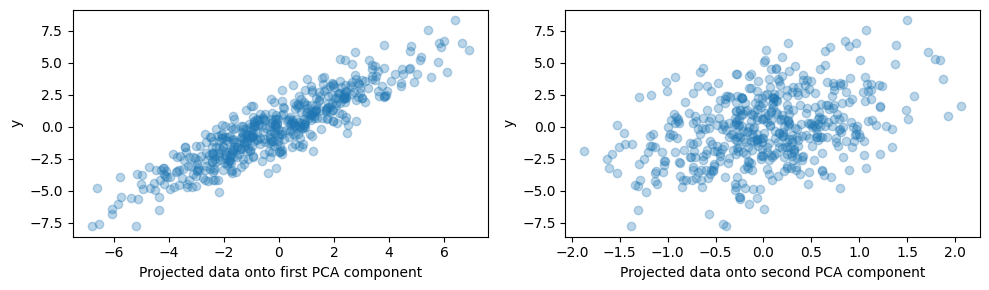

In [7]:
y = X.dot(pca.components_[0]) + X.dot(pca.components_[1])*1.5 + rng.normal(size=n_samples) / 2

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

axes[0].scatter(X.dot(pca.components_[0]), y, alpha=0.3)
axes[0].set(xlabel="Projected data onto first PCA component", ylabel="y")
axes[1].scatter(X.dot(pca.components_[1]), y, alpha=0.3)
axes[1].set(xlabel="Projected data onto second PCA component", ylabel="y")
plt.tight_layout()
plt.show()

PCR, R2 = 0.747255397356534
PLS, R2 = 0.7764047679027523


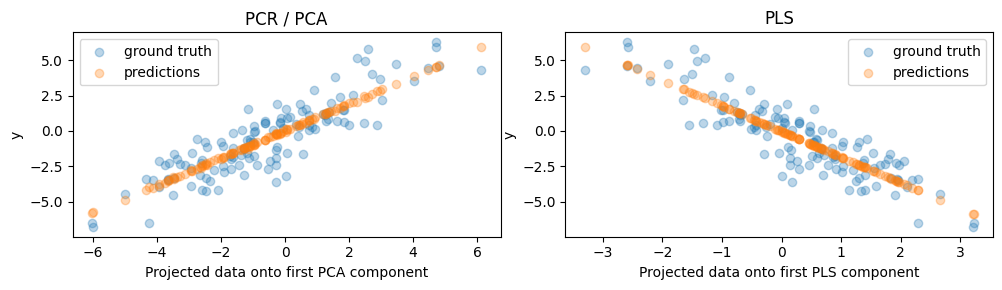

In [8]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rng)

pcr = make_pipeline(StandardScaler(), PCA(n_components=1), LinearRegression())
pcr.fit(X_train, y_train)
pca = pcr.named_steps["pca"]  # retrieve the PCA step of the pipeline

pls = PLSRegression(n_components=1)
pls.fit(X_train, y_train)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].scatter(pca.transform(X_test), y_test, alpha=0.3, label="ground truth")
axes[0].scatter(
    pca.transform(X_test), pcr.predict(X_test), alpha=0.3, label="predictions"
)
axes[0].set(
    xlabel="Projected data onto first PCA component", ylabel="y", title="PCR / PCA"
)
axes[0].legend()
print(f'PCR, R2 = {r2_score(y_test, pcr.predict(X_test))}')

axes[1].scatter(pls.transform(X_test), y_test, alpha=0.3, label="ground truth")
axes[1].scatter(
    pls.transform(X_test), pls.predict(X_test), alpha=0.3, label="predictions"
)
axes[1].set(xlabel="Projected data onto first PLS component", ylabel="y", title="PLS")
axes[1].legend()
print(f'PLS, R2 = {r2_score(y_test, pls.predict(X_test))}')

plt.tight_layout()
plt.show()

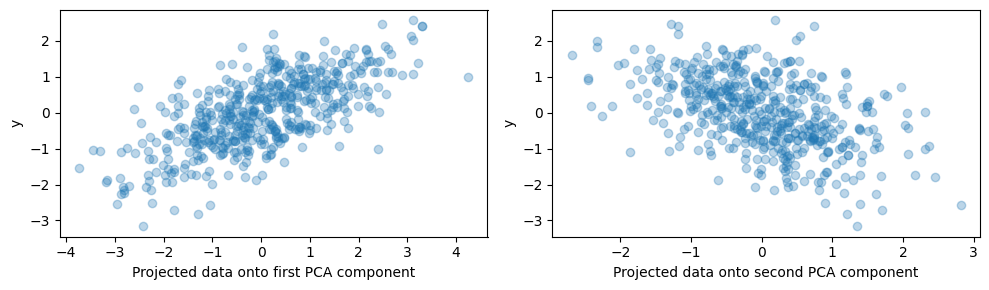

In [9]:
rng = np.random.RandomState(0)
n_samples = 500
cov = [[3, 2, 1], 
       [2, 4, 2],
       [1, 2, 5]
       ]
X = rng.multivariate_normal(mean=[0, 0, 0], cov=cov, size=n_samples)
pca = PCA(n_components=2).fit(X)

y = X.dot(np.array([-0.5, 0.5, 0.5])) + 0 * rng.normal(size=n_samples) / 10 #+ X.dot(pca.components_[0])*0.5 + X.dot(pca.components_[1])*3.5 + rng.normal(size=n_samples) / 10

X = StandardScaler().fit_transform(X)
y = StandardScaler().fit_transform(y[:, None])

#viz
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

axes[0].scatter(X.dot(pca.components_[0]), y, alpha=0.3)
axes[0].set(xlabel="Projected data onto first PCA component", ylabel="y")
axes[1].scatter(X.dot(pca.components_[1]), y, alpha=0.3)
axes[1].set(xlabel="Projected data onto second PCA component", ylabel="y")
plt.tight_layout()
plt.show()

#fit
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rng)

X_train = StandardScaler().fit_transform(X_train)
y_train = StandardScaler().fit_transform(y_train)

pcr = make_pipeline(PCA(n_components=2))
pcr.fit(X_train, y_train)

pls = PLSRegression(n_components=2)
pls.fit(X_train, y_train);

In [10]:
kdm = KlemeraDoubalEstimator(feature_selection_method='all')
kdm.fit(pd.DataFrame(X_train), y_train.ravel())

In [166]:
X_train_pca_transform = pcr.steps[0][1].transform(X_train)
X_train_pls_transform = pls.x_scores_

In [167]:
print('PCA1 explained covariance', np.cov(X_train_pca_transform[:, 0], y_train[:, 0])[0, 1])
print('PCA2 explained covariance', np.cov(X_train_pca_transform[:, 1], y_train[:, 0])[0, 1])

PCA1 explained covariance -0.7416661520914969
PCA2 explained covariance -0.6738050082414159


In [168]:
print('PLS1 explained covariance', np.cov(X_train_pls_transform[:, 0], y_train[:, 0])[0, 1])
print('PLS2 explained covariance', np.cov(X_train_pls_transform[:, 1], y_train[:, 0])[0, 1])

PLS1 explained covariance 1.0284891587788765
PLS2 explained covariance -0.40740325392675864


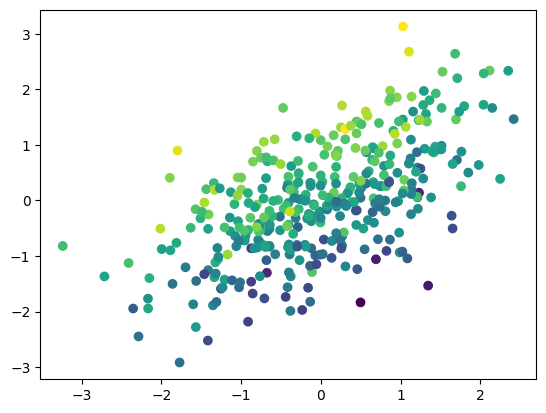

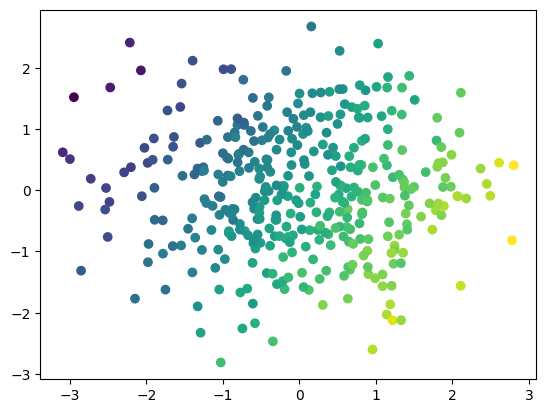

In [169]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
plt.show()

Xp_train = pls.x_scores_
plt.scatter(Xp_train[:, 0], Xp_train[:, 1], c=y_train)

# PLS vs KDM

In [13]:
kdm = KlemeraDoubalEstimator(feature_selection_method='all')
kdm.fit(pd.DataFrame(X_train), y_train.ravel())

In [14]:
m = kdm.model
m

,slope,intercept,rvalue,p-value,stderr,rse,r2,r_abs,fi,adj.p-value,weight
2,0.849618,-1.538604e-17,0.849618,1.106711e-105,0.027308,0.528811,0.721850,0.849618,3.038245,3.320133e-105,0.528811
1,0.576553,-5.155114e-17,0.576553,1.328290e-34,0.042306,0.819247,0.332414,0.576553,0.859033,1.992435e-34,0.819247
0,-0.026552,-1.121350e-17,-0.026552,6.082651e-01,0.051760,1.002324,0.000705,0.026552,0.026429,6.082651e-01,1.002324


In [15]:
n = 100
t = np.linspace(-3, 3 ,n)

X_kdm = np.zeros((n, 3))
X_kdm[:, 0] = m.loc[0, 'slope'] * t + m.loc[0, 'intercept']
X_kdm[:, 1] = m.loc[1, 'slope'] * t + m.loc[1, 'intercept']
X_kdm[:, 2] = m.loc[2, 'slope'] * t + m.loc[2, 'intercept']

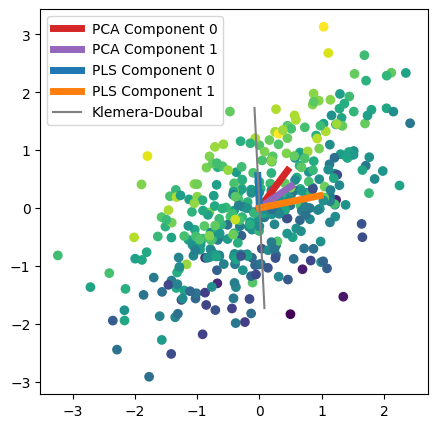

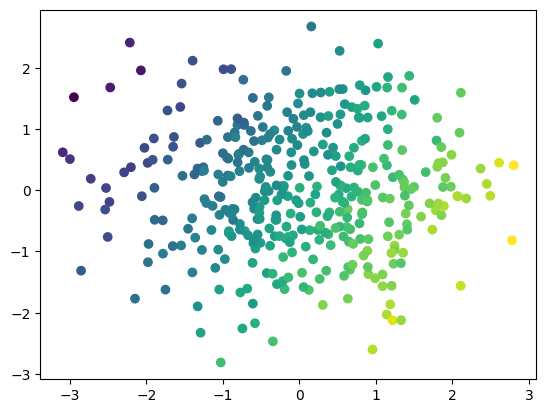

In [16]:
plt.figure(figsize=(5,5))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)


plot_directions(pca.components_, j=3, prefix='PCA')
plot_directions(pls.x_weights_.T, j=0, prefix='PLS')

X_kdm = np.zeros((n, 2))
X_kdm[:, 0] = m.loc[0, 'slope'] * t + m.loc[0, 'intercept']
X_kdm[:, 1] = m.loc[1, 'slope'] * t + m.loc[1, 'intercept']
plt.plot(X_kdm[:, 0], X_kdm[:, 1], color='grey', label='Klemera-Doubal')
# plot_directions(pls.x_rotations_.T, j=0)
# plot_directions(pls.x_loadings_.T, j=3)

plt.legend()


plt.show()
Xp_train = pls.x_scores_
plt.scatter(Xp_train[:, 0], Xp_train[:, 1], c=y_train);



# PLS in case of methylation data

In [146]:
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# open or donwload data
import os
gse = 'GSE41169'
p = f'data/METH/{gse}/'
if os.path.exists(f'{p}GSE41169_data.pkl') and os.path.exists(f'{p}GSE41169_meta.pkl'):
    df = pd.read_pickle(f'{p}GSE41169_data.pkl')
    meta = pd.read_pickle(f'{p}GSE41169_meta.pkl')
    print('Ok! Data is here!')
else:
    if os.path.exists(p) == False:
        os.mkdir(p)
    #use this code block for downloading and storing data 
    #(it's better to store because data is quite large)
    from biolearn.data_library import DataLibrary
    #Load up GSE41169 blood DNAm data
    data_source = DataLibrary().get(gse)
    data=data_source.load()
    df = data.dnam
    meta = data.metadata
    df.to_pickle(f'{p}GSE41169_data.pkl')
    meta.to_pickle(f'{p}GSE41169_meta.pkl')

Ok! Data is here!


In [147]:
y = meta['age']
corC = df.T.corrwith(y)
topcorr = corC.abs().sort_values(ascending=False)[:50000]

In [148]:
X = df.loc[topcorr.index].T * 100
y = meta['age']
#drop nan values
X = X.dropna(axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [ ]:
#baseline linear model (Lasso)
model = LassoCV(n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test model trained on 10000 top correlated features")
print(f"MAE={mean_absolute_error(y_test, y_pred)} years")

In [8]:
#second baseline linear model (EN)
model = ElasticNetCV(n_alphas=30, n_jobs=-1, l1_ratio=0.5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test model trained on 10000 top correlated features")
print(f"MAE={mean_absolute_error(y_test, y_pred)} years")

Test model trained on 10000 top correlated features
MAE=2.7180486041784206 years


In [9]:
#PLS model
mae_list = []
for i in range(1, 40):
    pls = PLSRegression(n_components=i)
    pls.fit(X_train, y_train)
    y_pred_pls = pls.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred_pls)
    # print("PLS model trained on 10000 top correlated features")
    # print(f"MAE={mae} years")
    mae_list.append(mae)

/home/shappiron/anaconda3/envs/bioage/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 32
  warnings.warn(f"Y residual is constant at iteration {k}")
/home/shappiron/anaconda3/envs/bioage/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 32
  warnings.warn(f"Y residual is constant at iteration {k}")
/home/shappiron/anaconda3/envs/bioage/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 32
  warnings.warn(f"Y residual is constant at iteration {k}")
/home/shappiron/anaconda3/envs/bioage/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 32
  warnings.warn(f"Y residual is constant at iteration {k}")
/home/shappiron/anaconda3/envs/bioage/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning:

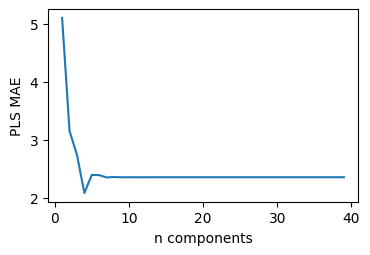

In [10]:
plt.figure(figsize=(4,2.5))
plt.plot(range(1, 40), mae_list)
plt.gca().set(ylabel='PLS MAE', xlabel='n components');

In [149]:
def print_metrics(y_true, y_pred, return_result=False):
    r2 = r2_score(y_true, y_pred)
    r = np.corrcoef(y_true, y_pred)[0, 1]
    mae = mean_absolute_error(y_true, y_pred)
    print(f"MAE = {mae:.3f}")
    print(f"R2 = {r2:.3f}")
    print(f"r = {r:.3f}")
    if return_result:
        return (mae, r2, r)

In [157]:
pls = PLSRegression(n_components=4, scale=False)
pls.fit(X_train, y_train)
y_pred_pls = pls.predict(X_test)

print("PLS model trained on 10000 top correlated features")
print_metrics(y_test, y_pred_pls.ravel(), return_result=False)

PLS model trained on 10000 top correlated features
MAE = 2.686
R2 = 0.917
r = 0.985


In [158]:
#transformed PLS features can serve for simple linear regression training
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF
Xp_train = pls.transform(X_train)
Xp_test = pls.transform(X_test)

postpls = LinearRegression()
# kernel = (
#           1 * RBF(length_scale=1, length_scale_bounds=(1e-2, 100)) + 
#           WhiteKernel(noise_level=1, noise_level_bounds=(1e-1, 100))
#           )
# kernel = (
#           1 * RBF(length_scale=1,) + 
#           WhiteKernel(noise_level=1,)
#           )
# postpls = GaussianProcessRegressor(kernel=kernel, normalize_y=False, n_restarts_optimizer=5)

postpls.fit(Xp_train, y_train)
y_pred_postpls = postpls.predict(Xp_test)

mae = mean_absolute_error(y_test, y_pred_postpls)
print("LR model trained on PLS transformed 10000 top correlated features")
print_metrics(y_test, y_pred_postpls.ravel(), return_result=False)

LR model trained on PLS transformed 10000 top correlated features
MAE = 2.686
R2 = 0.917
r = 0.985


In [160]:
class MyStandardScaler():
    def __init__(self) -> None:
        self.mean = None
        self.std = None
    
    def fit(self, X):
        self.mean = X.mean(axis=0)
        self.std = X.std(axis=0)

    def transform(self, X):
        return (X - self.mean) #/ self.std

In [162]:
import numpy as np
# what if we add missing values to PLS
scaler = MyStandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
# X_train_scaled = X_train.copy()
# X_test_scaled = X_test.copy()

#remove k random features
k_missing = 40000
np.random.seed(4)
drop_ids = np.random.choice(X_train.shape[1], size=k_missing, replace=False)

#get full PLS weights and loadings matrices
V = pls.x_weights_  # p x k
L = pls.x_loadings_ # p x k

mask = np.ones(V.shape[0], dtype=bool)
mask[drop_ids] = False

#remove rows of corresponding missing features
Vnew = V[mask] 
Lnew = L[mask]

Rnew = (Vnew @ np.linalg.pinv(Lnew.T @ Vnew)) #construct a new rotation matrix

Xp_test_withmissing = X_test_scaled.iloc[:, mask] @ Rnew #transform test set with missing features

y_pred_postpls_withmissing = postpls.predict(Xp_test_withmissing)

print(f"LR model trained on PLS transformed {V.shape[0]} top correlated features with {k_missing} missing features in test")
print_metrics(y_test, y_pred_postpls_withmissing.ravel(), return_result=False)

LR model trained on PLS transformed 46824 top correlated features with 40000 missing features in test
MAE = 2.792
R2 = 0.918
r = 0.980


In [37]:
from kdm.kdm import KlemeraDoubalEstimator
kdm = KlemeraDoubalEstimator(feature_selection_method='all')
kdm.fit(X_train_prep, y_train)

/home/shappiron/anaconda3/envs/bioage/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [44]:
import numpy as np
np.corrcoef(kdm.model.loc[pls.feature_names_in_, 'slope'], V[:, 0])

array([[1., 1.],
       [1., 1.]])

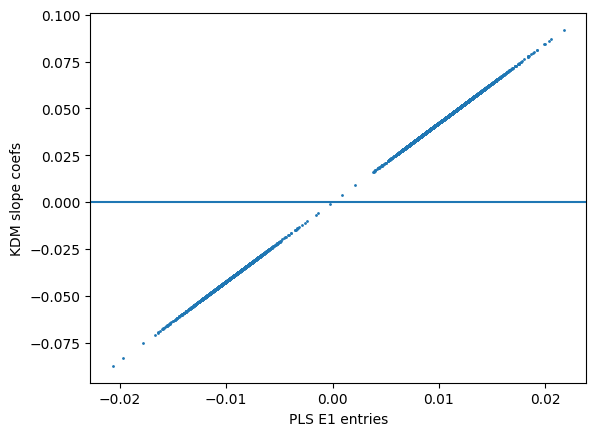

In [308]:
plt.scatter(V[:, 0], kdm.model.loc[pls.feature_names_in_, 'slope'], s=1)
plt.gca().set(xlabel = 'PLS E1 entries',
              ylabel = 'KDM slope coefs'
              )
plt.axhline(0)

In [207]:
for i in range(X_scores.shape[1]):
    print(np.corrcoef(X_scores[:, i], y_train)[0, 1])

0.7886410149099317
-0.47531153011123484
0.3059704831782033
-0.19623782663013126


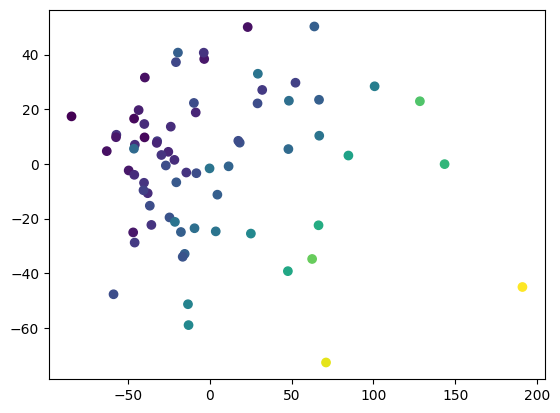

In [211]:
plt.scatter(X_scores[:, 0], X_scores[:, 1], c = y_train.ravel())

[Text(0.5, 0, 'Eig1'), Text(0, 0.5, 'Coef')]

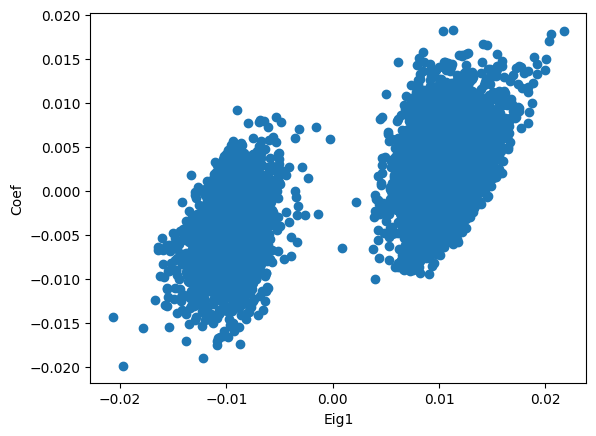

In [221]:
plt.scatter(V[:, 0], pls.coef_)
plt.gca().set(xlabel='Eig1', ylabel='Coef')

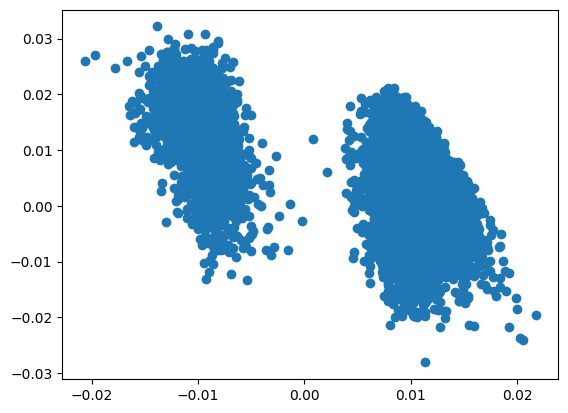

In [212]:
plt.scatter(V[:, 0], V[:, 1])

In [159]:
pls.x_rotations_

array([[ 0.02173441, -0.0260262 ,  0.03367122, -0.03235549],
       [ 0.02030555, -0.02972344,  0.03134688, -0.02280367],
       [-0.02065491,  0.03226294, -0.02003856,  0.01479317],
       ...,
       [ 0.00717477,  0.00138077, -0.00053521,  0.00861235],
       [ 0.0099821 ,  0.00666656, -0.0136722 , -0.00284368],
       [ 0.00967169, -0.0075855 ,  0.01773422, -0.00819757]])

# Test PLS on single cells

In [373]:
from glob import glob
from os.path import basename, splitext
from tqdm import tqdm

#bulk reference (train data)
import pickle
met = pickle.load(open('data/METH/GSE120132_metlevs_processed_annotated_all_sites.pkl', 'rb'))

#sc test data
scmeta = pd.read_csv('data/METH/SRA344045_metadata.tsv', sep='\t', index_col=0)
sample_folder = 'data/METH/SRA344045_processed/PROCESSED/'
sc_true_age = scmeta['Age(num)'].fillna(0.)
sample_list = glob(sample_folder + '*.tsv')
sample_list[:3]

['data/METH/SRA344045_processed/PROCESSED/SRR3136646.tsv',
 'data/METH/SRA344045_processed/PROCESSED/SRR3136627.tsv',
 'data/METH/SRA344045_processed/PROCESSED/SRR3136660.tsv']

In [374]:
#select tissue
met = met[met['Tissue']=='Liver']

In [375]:
#data preparation
X = met.drop(['Strain', 'Tissue', 'Age', 'Sex'], axis=1)
meta = met[['Strain', 'Tissue', 'Sex']]
y = met['Age']

corC = X.corrwith(y)
topcorr = corC.abs().sort_values(ascending=False)[:50000]
X = X[topcorr.index] 

#zero filtering
n = X.shape[0]
zero_threshold = 0.7
X = X.loc[:, (X == 0).sum(axis=0) / n < zero_threshold] #drop columns with more than 70% of zeros

#nan filtering
n = X.shape[0]
nan_threshold = 0.7
X = X.loc[:, X.isna().sum(axis=0) / n < nan_threshold] #drop columns with more than 70% of zeros


# tissue-wise normalization 
# X_c = X - X.groupby(meta['Tissue']).transform('mean')
# X_z = X_c / X.groupby(meta['Tissue']).transform('std')
# X = X_z.copy()

X = X.dropna(axis=1)
#X = X.fillna(0.0)

#standard scaler
# scaler = StandardScaler()
# X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

#split to train | test
X_train, X_test, y_train, y_test, meta_train, meta_test = train_test_split(X, y, meta, 
                                                              test_size=0.25, 
                                                              stratify=meta['Tissue'], random_state=200)

#splitting data in cv folds with stratification (for ElasticNet)
# cv = 5
# folds = [train_test_split(X_train, y_train, test_size=0.2, random_state=i, stratify=meta_train['Tissue']) for i in range(cv)]

In [378]:
#train PLS model
pls = PLSRegression(n_components=1, scale=True)
pls.fit(X_train, y_train)

y_pred_train_pls = pls.predict(X_train)
y_pred_test_pls = pls.predict(X_test)

print("PLS model trained on 10000 top correlated features")
print("Train metrics")
print_metrics(y_train.ravel(), y_pred_train_pls.ravel())
print()
print("Test metrics")
print_metrics(y_test, y_pred_test_pls.ravel())

PLS model trained on 10000 top correlated features
Train metrics
MAE = 0.816
R2 = 0.980
r = 0.990

Test metrics
MAE = 1.363
R2 = 0.856
r = 0.984


In [379]:
#transformed PLS features can serve for simple linear regression training
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF
Xp_train = pls.transform(X_train)
Xp_test = pls.transform(X_test)

postpls = LinearRegression()
# kernel = (
#           1 * RBF(length_scale=1, length_scale_bounds=(1e-2, 100)) + 
#           WhiteKernel(noise_level=1, noise_level_bounds=(1e-1, 100))
#           )
# kernel = (
#           1 * RBF(length_scale=1,) + 
#           WhiteKernel(noise_level=1,)
#           )
# postpls = GaussianProcessRegressor(kernel=kernel, normalize_y=False, n_restarts_optimizer=5)

postpls.fit(Xp_train, y_train)
y_pred_postpls = postpls.predict(Xp_test)

mae = mean_absolute_error(y_test, y_pred_postpls)
print("LR model trained on PLS transformed 10000 top correlated features")
print(f"MAE={mae} years")

LR model trained on PLS transformed 10000 top correlated features
MAE=1.36336481542273 years


In [380]:
class MyStandardScaler():
    def __init__(self, eps=0.01, mvals=False) -> None:
        self.mean = None
        self.std = None
        self.eps = 0.01
        self.mvals=mvals
    
    def fit(self, X):
        X_ = X.copy()
        if self.eps is not None:
            X_ = X_.replace(0., self.eps)
            X_ = X_.replace(1., 1 - self.eps)
        if self.mvals:
            X_ = np.log2(X_ / (1 - X_))
        self.mean = X_.mean(axis=0)
        self.std = X_.std(axis=0)

    def transform(self, X, selection=None):
        X = X.copy() if selection is None else X[selection]
        #truncating values of 1 and 0 (which are not possible in True beta distribution)
        if self.eps is not None:
            X = X.replace(0., self.eps)
            X = X.replace(1., 1 - self.eps)
        #transformation to m values, i.e. log2[b / (1-b)], where b is beta value
        if self.mvals:
            X = np.log2(X / (1 - X))
        if selection is not None:
            return (X - self.mean.loc[selection]) / self.std.loc[selection]
        else:
            return (X - self.mean) / self.std
        
#second
class MethylationScaler():
    def __init__(self, normalizer=0.5) -> None:
        self.normalizer = normalizer
    
    def fit(self, X):
        return None

    def transform(self, X, selection=None):
        X = X.copy() if selection is None else X[selection]
        return X - self.normalizer
    
#third
class SCMinMaxScaler():
    def __init__(self) -> None:
        self.min = None
        self.max = None
    
    def fit(self, X):
        X_ = X.copy()
        self.max = X_.max(axis=0)
        self.min = X_.min(axis=0)

    def transform(self, X, selection=None):
        X = X.copy() if selection is None else X[selection]

        if selection is not None:
            return X * self.max.loc[selection] + (X - 1).abs() * self.min.loc[selection]
        else:
            return X * self.max + (X - 1).abs() * self.min 

In [345]:
# mx = X_train[intersection].max(axis=0)
# mn = X_train[intersection].min(axis=0)


# X_test_scaled * mx + (X_test_scaled - 1).abs() * mn

#X_train.where()X_train.max(axis=0)

In [394]:
y_pred_postpls_withmissing_sc_list = []
number_of_sites = []
top_sites = 100

#get full PLS weights and loadings matrices
V = pls.x_weights_
L = pls.x_loadings_

# what if we add missing values to PLS
scaler = MyStandardScaler(eps=0.00, mvals=False)
# scaler = MethylationScaler(normalizer=0.0)
# sc_scaler = SCMinMaxScaler()
# sc_scaler.fit(X_train)
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

for l in tqdm(sample_list):
    sc_sample = pd.read_csv(l, sep='\t', index_col=0)

    intersection = sc_sample.index.intersection(X_train.columns)
    intersection = topcorr.index.intersection(intersection)[:top_sites]
    # X_test_scaled = sc_scaler.transform(sc_sample.T, intersection)
    # X_test_scaled = scaler.transform(sc_sample.T, intersection)
    # X_test_scaled = scaler.transform(X_test_scaled, intersection)

    mask = np.zeros(V.shape[0], dtype=bool)
    mask[X_train.columns.get_indexer(intersection)] = True

    #remove rows of corresponding missing features
    Vnew = V[mask] 
    Lnew = L[mask]

    # closest = (np.abs(X_train[intersection] - sc_sample.T[intersection].values) * Vnew[:, 0]).sum(axis=1).sort_values(ascending=True).index[0]
    closest = np.abs(X_train[intersection] - sc_sample.T[intersection].values).sum(axis=1).sort_values(ascending=True).index[0]
    X_test_scaled = X_train_scaled.loc[closest, intersection].to_frame().T


    Rnew = (Vnew @ np.linalg.pinv(Lnew.T @ Vnew)) #construct a new rotation matrix

    Xp_test_withmissing = X_test_scaled @ Rnew #transform test set with missing features
    y_pred_postpls_withmissing = postpls.predict(Xp_test_withmissing)

    y_pred_postpls_withmissing_sc_list.append(y_pred_postpls_withmissing)
    number_of_sites.append(X_test_scaled.shape[1])

cell_names = [splitext(basename(s))[0] for s in sample_list]
predicted_ages = pd.DataFrame(y_pred_postpls_withmissing_sc_list, index=cell_names, columns=['pls age'])
pred_true = predicted_ages.merge(sc_true_age, left_index=True, right_index=True)

100%|██████████| 26/26 [00:42<00:00,  1.62s/it]


500


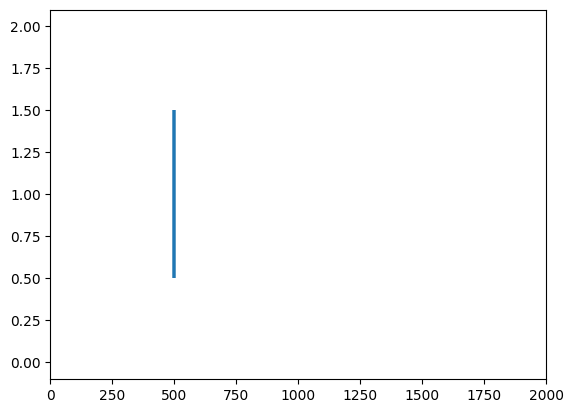

In [386]:
plt.eventplot(number_of_sites)
plt.xlim([0, 2000])
print(min(number_of_sites))

MAE = 4.209
R2 = 0.792
r = 0.920


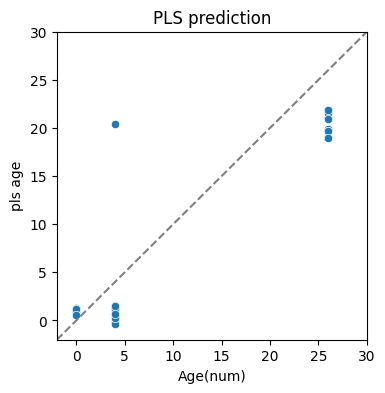

In [407]:
import seaborn as sns

print_metrics(pred_true['Age(num)'], pred_true['pls age'])

plt.figure(figsize=(4,4))
plt.title('PLS prediction')
sns.scatterplot(data=pred_true, y='pls age', x='Age(num)');
plt.axline([0,0], [1,1], color='grey', ls='--')
plt.ylim([-2, 30])
plt.xlim([-2, 30])
plt.show()

In [144]:
# mae = mean_absolute_error(y_test, y_pred_postpls_withmissing)
# print(f"LR model trained on PLS transformed {V.shape[0]} top correlated features with {k_missing} missing features in test")
# print(f"MAE={mae} years")

In [ ]:
# import numpy as np
# # what if we add missing values to PLS
# scaler = MyStandardScaler()
# scaler.fit(X_train)
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# #remove k random features
# k_missing = 92000
# np.random.seed(4)
# drop_ids = np.random.choice(X_train.shape[1], size=k_missing, replace=False)

# #get full PLS weights and loadings matrices
# V = pls.x_weights_
# L = pls.x_loadings_

# mask = np.ones(V.shape[0], dtype=bool)
# mask[drop_ids] = False

# #remove rows of corresponding missing features
# Vnew = V[mask] 
# Lnew = L[mask]

# Rnew = (Vnew @ np.linalg.pinv(Lnew.T @ Vnew)) #construct a new rotation matrix

# Xp_test_withmissing = X_test_scaled.iloc[:, mask] @ Rnew #transform test set with missing features

# y_pred_postpls_withmissing = postpls.predict(Xp_test_withmissing)

# mae = mean_absolute_error(y_test, y_pred_postpls_withmissing)
# print(f"LR model trained on PLS transformed {V.shape[0]} top correlated features with {k_missing} missing features in test")
# print(f"MAE={mae} years")